# Evaluate Offsets From NISAR processor

In [1]:
%load_ext autoreload
%autoreload 2
import nisarhdf 
from osgeo import gdal
import os
import glob
import numpy as np
import rioxarray
from nisarhdf import writeMultiBandVrt
import h5py
from datetime import datetime
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
def createDivider(ax, colorBarPosition='right', colorBarSize='5%',
                   colorBarPad=0.05):
    '''
    Create divider for color bar
    '''
    divider = make_axes_locatable(ax)  # Create space for colorbar
    return divider.append_axes(colorBarPosition, size=colorBarSize,
                               pad=colorBarPad)

def colorBar(pos, ax, colorBarLabel, colorBarPosition, colorBarSize,
              colorBarPad, labelFontSize, plotFontSize, extend='max',
              fontScale=1):
    '''
    Color bar for image
    '''
    # Create an divided axis for cb
    cbAx = createDivider(ax, colorBarPosition=colorBarPosition,
                             colorBarSize=colorBarSize,
                               colorBarPad=colorBarPad)
    # Select orientation
    orientation = {'right': 'vertical', 'left': 'vertical',
                   'top': 'horizontal',
                   'bottom': 'horizontal'}[colorBarPosition]

    cb = plt.colorbar(pos, cax=cbAx, orientation=orientation,
                      extend=extend)
    cb.set_label(colorBarLabel, size=labelFontSize * fontScale)
    cb.ax.tick_params(labelsize=plotFontSize * fontScale)
    if colorBarPosition in ['right', 'left']:
        cbAx.yaxis.set_ticks_position(colorBarPosition)
        cbAx.yaxis.set_label_position(colorBarPosition)
    elif colorBarPosition in ['top', 'tottom']:
        cbAx.xaxis.set_ticks_position(colorBarPosition)
        cbAx.xaxis.set_label_position(colorBarPosition)

## Processing Paramters

This notebook evaluates data from ALOS 2 for frame **5280** from orbits **49672** and **49879**.

Both sets of data were processed starting at range & azimuth SLC pixel coordinates 266 & 266 and estimates are computed every 30 pixels in range and 15 pixels in azimuth for both processors.

### NISAR Workflow

The NISAR data were process with the following:

|Layer |alongTrackSearchWindowSize |alongTrackWindowSize |AlongTrackFFTSize |slantRangeSearchWindowSize |slantRangeWindowSize |slantRangeFFTSize |
|------ |----- |----- |----- |----- |----- |----- |
|1 |64 |32 |96| 64 |64 |128 |
|2 |64 |64 |128|64 |96 |160 |
|3 |64 |128 |192 |64 |196 |260 |

With these parameters a smaller chip (alongTrackWindowSize x slantRangeWindowSize) is moved around with search radius of $alongTrackSearchWindowSize \over 2$ x $slantRangeSearchWindowSize \over 2$, which translates to FFT sizes of $(alongTrackSearchWindowSize + alongTrackWindowSize)$ x $(slantRangeSearchWindowSize x slantRangeWindowSize)$. With overampling, these numbers all double.

I am not sure what the actual internal FFT size is but it should actually be bigger so that correlation peak can be adequately sampled as shown in the figure below. **The FFT sizes in the table represent my assumption and may not be correct.**


![Definition of terms used for offset tracking.](Windows.png)

### GrIMP Workflow

The GrIMP tracker does a straight forward cross correlation on as illustrated above, which includes padding for the correlation oversampling.  No special pre-processing of the data is applied (e.g., deramping) other than oversampling the input data by a factor of 2. 

For this experiment, the following parameters are used:

|Layer |alongTrackSearchWindowSize |alongTrackWindowSize |AlongTrackFFTSize |slantRangeSearchWindowSize |slantRangeWindowSize |slantRangeFFTSize |
|------ |----- |----- |----- |----- |----- |----- |
|1 |64 |32 |104 |64 |64 |136 |
|2 |68 |64 |140 |64 |96 |168 |
|3 |64 |128 |200 |66 |196 |270 |

Note the search window sizes differ slightly from those used for NISAR so that the FFT size is factorable into realively small primes for FFTW.

The correlation peak is sampled in the surrounding 4x4 pixel area (8x8 in oversampled) and oversampled by a factor of 20 (2x since the data already overampled and an additional 10x), for 1/20th of a pixel quantization. The location of the peak is determined and converted to a fractional pixel offsets. Increasing this value does not seem to lead to any improvements in the results.  Typically some smoothing is applied to the result, which reduces the quantization error.

## DEM and Offset scaling.

The NISAR offsets have been scaled to meters and had the geometry removed. For this evaluation, we add the geometry back and scale to pixels using the Copernicus WGS84 DEM. Note the geometry is very smooth and does not affect the random noise at the scale examined below. Thus all results are expressed in pixels and include the geometric shift as well as any arbitrary offsets with how the images are aligned after processing.

## Read Offsets

Use rioxarray to open the products. The NISAR offsets have been broken out of the HDFs into flat binary files.

In [4]:
keys = ['64x32', '96x64', '196x128']
#bandNames = 
grimpFiles = dict(zip(keys, [f'../../49672_5280/amplitude/testoff{key}.vrt' for key in keys]))
grimpOffsets, grimpOffsetsCulled = {}, {}
for key in keys:
    grimpOffsets[key] = rioxarray.open_rasterio(grimpFiles[key], band_as_variable=True, mask_and_scale=True)
    bandNames = [getattr(grimpOffsets[key][b], 'Description') for b in grimpOffsets[key].data_vars]
    print(bandNames)
    grimpOffsets[key] = grimpOffsets[key].rename(dict(zip([x for x in grimpOffsets[key].data_vars], bandNames)))
    grimpOffsetsCulled[key] = \
        rioxarray.open_rasterio(grimpFiles[key].replace('.vrt', '.cull.vrt'), band_as_variable=True, mask_and_scale=True)
    bandNamesCulled = [getattr(grimpOffsetsCulled[key][b], 'Description') for b in grimpOffsetsCulled[key].data_vars]
    grimpOffsetsCulled[key] = grimpOffsetsCulled[key].rename(dict(zip([x for x in grimpOffsetsCulled[key].data_vars], bandNamesCulled)))


['RangeOffsets', 'AzimuthOffsets', 'Correlation']
['RangeOffsets', 'AzimuthOffsets', 'Correlation']
['RangeOffsets', 'AzimuthOffsets', 'Correlation']


In [5]:
offsetsGeom = rioxarray.open_rasterio('../../49672_5280/workingDir/offsets.geom.vrt', band_as_variable=True, mask_and_scale=True)
offsetsGeom = offsetsGeom.rename({'band_1': 'RangeOffsets', 'band_2': 'AzimuthOffsets'})
offsetsSim = rioxarray.open_rasterio('../../49672_5280/workingDir/offsets.vrt', band_as_variable=True, mask_and_scale=True)
offsetsSim = offsetsSim.rename({'band_1': 'RangeOffsets', 'band_2': 'AzimuthOffsets'})

In [6]:
files = [f for f in sorted(glob.glob('../../49672_5280/workingDir/offsets.layer?.vrt'))]
nisarFiles = dict(zip(keys, files))
nisarOffsets, nisarOffsetsCulled = {}, {}
for key in keys:
    nisarOffsets[key] = rioxarray.open_rasterio(nisarFiles[key], band_as_variable=True, mask_and_scale=True)
    nisarOffsets[key] = nisarOffsets[key].rename(dict(zip([x for x in nisarOffsets[key].data_vars], bandNames)))
    nisarOffsetsCulled[key] = \
        rioxarray.open_rasterio(nisarFiles[key].replace('.vrt', '.cull.vrt'), band_as_variable=True, mask_and_scale=True)
    nisarOffsetsCulled[key] = nisarOffsetsCulled[key].rename(dict(zip([x for x in nisarOffsetsCulled[key].data_vars], bandNamesCulled)))
    for band in bandNames:
        if band in offsetsGeom.data_vars:
            getattr(nisarOffsetsCulled[key], band).data[:] += offsetsGeom[band][:]
            getattr(nisarOffsets[key], band).data[:] += offsetsGeom[band][:]

In [7]:
offsetsComplex = rioxarray.open_rasterio('../../49672_5280/testoff.cull.vrt', band_as_variable=True, mask_and_scale=True)
bandNames = [getattr(offsetsComplex[b], 'Description') for b in offsetsComplex.data_vars]
complexOffsets = offsetsComplex.rename(dict(zip([x for x in offsetsComplex.data_vars], bandNames)))

## Profile Plots

Plot across and along track profiles.

In [8]:
colors = dict(zip(keys, ['r', 'k', 'dodgerblue']))

### Unculled Offsets

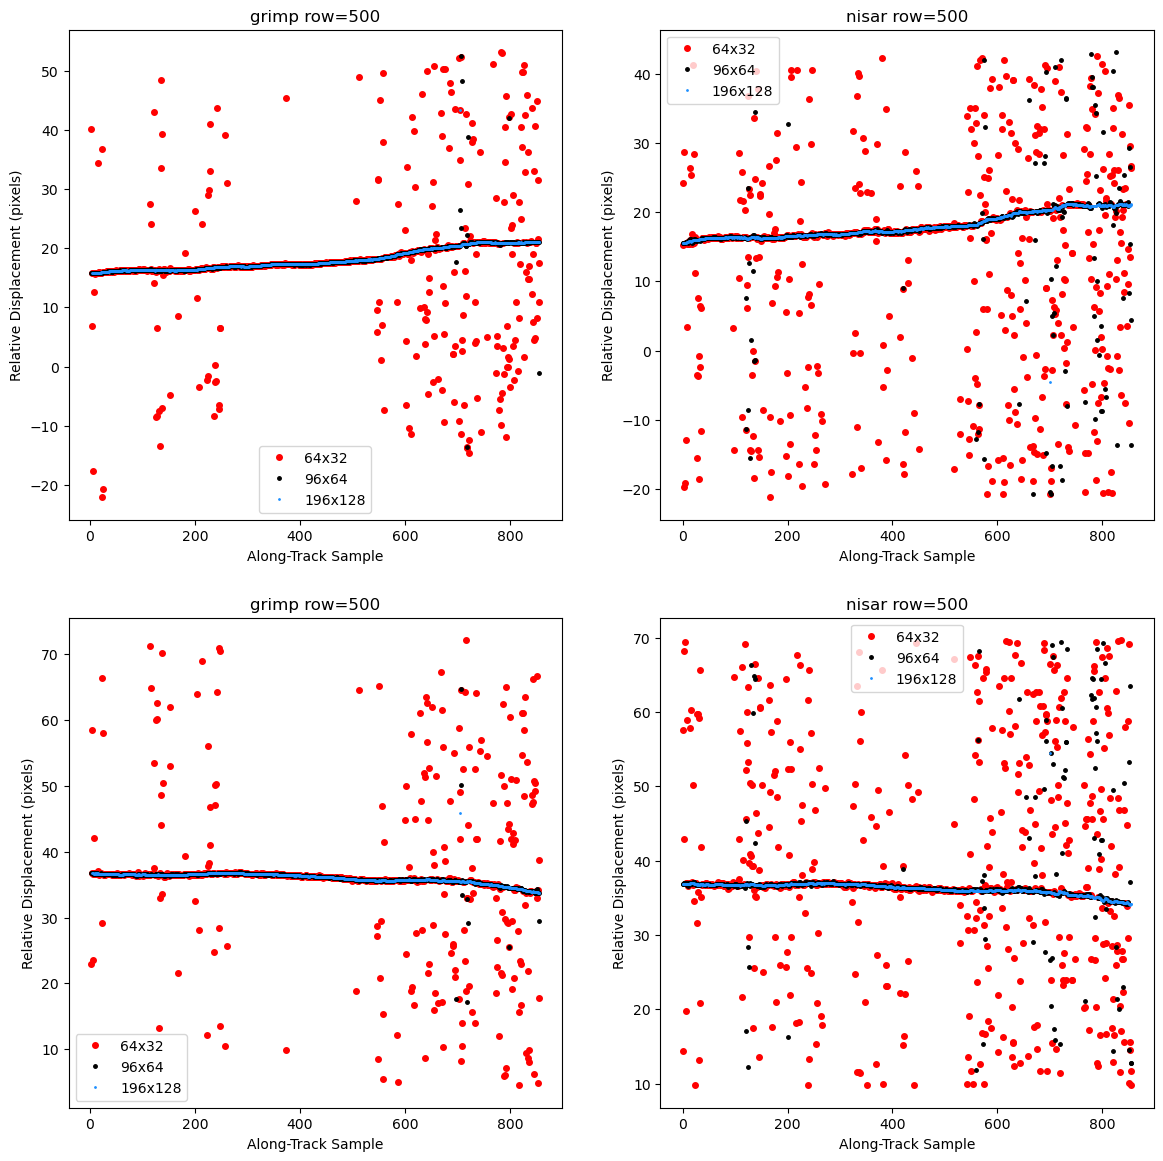

In [9]:
fig, axes = plt.subplots(2, 2, figsize=(14, 14))
row = 500
for band, ax in zip(bandNames, axes):
    for key, ms in zip(keys, [8, 5, 2]):
        ax[0].plot(getattr(grimpOffsets[key], band)[row, :], '.', color=colors[key], label=key, markersize=ms)
        ax[1].plot(getattr(nisarOffsets[key], band)[row, :], '.', color=colors[key], label=key, markersize=ms)  
    for a, source in zip(ax, [f'grimp row={row}', f'nisar row={row}']):
        a.set_title(source)
        a.legend()
        #a.set_ylim(ylim)
        a.set_ylabel('Relative Displacement (pixels)')
        a.set_xlabel('Along-Track Sample')

These plots aren't particularly useful because of the large number of outliers.

### Culled Offsets

Both sets of offsets were run through the GRiMP culling tool. This tool does the following:

* Examines the neighborhood in a box around each pixel (7x7 in this example),
* Fits a plane to the data and removes it,
* Discards outliers larger than some threshold (3 in each direction for this case),
* Discards points with few nearby good samples (must have > 10 good samples in neighborhood),
* Estimates the sigma for the remaining samples (subtracts 3 from N to account for the plane fit),
* Averages the surounding pixels (3x3 avg in this case),
* Scales the estimated sigmas to account for the averaging.

The same parameters were used for each layer of each data set.

Note the NISAR offsets been rescaled back to pixel units and they have had the geometry added back, which as computed using a 90-m version of Copernicus DEM referenced to the WGS84 ellipsoid. I compared this DEM with the 30-m DEM Virginia sent and the results are entirely in keeping with the differences you would expect with the 30 vs 90 (meter to sub-meter scale differences on the flat ice sheet topography).  Any differences, are not the result of the DEM.

Every known effort has been made to post process the offsets the same way to ensure an apples-to-apples comparison.

I have also included a non-apples to apples, by including output from the matcher that uses complex matching.  Here the baseline was used to flatten the complex images before matching (just the complex case). If the complex matcher fails (it worked 83% of the time), it tries 96x64 (1.1%) and if that fails it makes a last attempt with 196x128 (12.8%). The complex performance is not quite as good as the largest chip, but the resolution is much better (the effective width of the chip is 24x24 pixels compared to 196x128). So while its labelled complex, its technically a hybrid (but 83% complex).

In [10]:
def interpMissing(y):
    missing = np.isnan(y)
    good = np.isfinite(y)
    x = np.arange(0, len(y), 1)
    y[missing] = np.interp(x[missing], x[good], y[good])
    return y

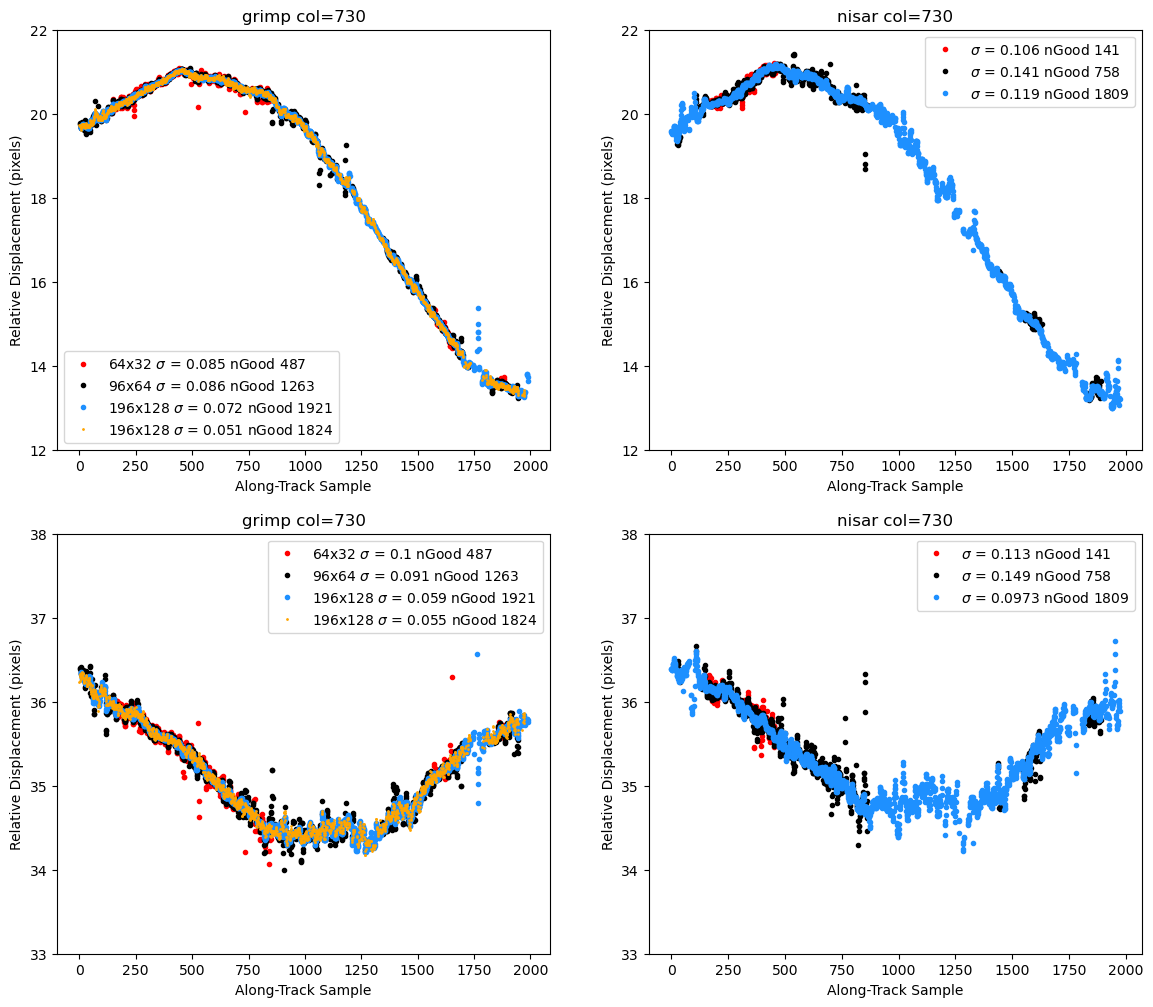

In [11]:
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
col = 730
# Loop on offset type
for band, ax, ylim in zip(bandNames, axes, [[12, 22], [33, 38]] ):
    # Estimate a smoothed version of the smoothest data (196x128)
    dataGrimpSmooth = interpMissing(np.convolve(np.array(getattr(grimpOffsetsCulled['196x128'], band)[:, col]), np.ones(25)/25))
    dataNisarSmooth = interpMissing(np.convolve(np.array(getattr(nisarOffsetsCulled['196x128'], band)[:, col]), np.ones(25)/25))
    # Loop on window sizes
    for key in keys:
        # extract along track for col
        dataGrimp = np.array(getattr(grimpOffsetsCulled[key], band)[:, col])
        dataNisar = getattr(nisarOffsetsCulled[key], band)[:, col]
        # Estimate sigma of high-freq content.
        sigmaG = np.nanstd(dataGrimpSmooth[25:-25] - dataGrimp[13:-13]).item()
        sigmaN = np.nanstd(dataNisarSmooth[25:-25] - dataNisar[13:-13]).item()
        # plot results
        labelg = f'{key} $\sigma$ = {sigmaG:.2} nGood {np.sum(np.isfinite(dataGrimp)).item()}'
        ax[0].plot(dataGrimp, '.', color=colors[key], label=labelg)
        labeln = f'$\sigma$ = {sigmaN:.3} nGood {np.sum(np.isfinite(dataNisar)).item()}'
        ax[1].plot(dataNisar, '.', color=colors[key], label=labeln)
    dataCmpx = getattr(complexOffsets, band)[:, col]
    sigmaG = np.nanstd(dataGrimpSmooth[25:-25] - dataCmpx[13:-13]).item()
    labelg = f'{key} $\sigma$ = {sigmaG:.2} nGood {np.sum(np.isfinite(dataCmpx)).item()}'
    ax[0].plot(dataCmpx, '.', color='orange', label=labelg, markersize=2)
  
  
    for a, source in zip(ax, [f'grimp col={col}', f'nisar col={col}']):
        a.set_title(source)
        a.legend()
        a.set_ylim(ylim)
        a.set_ylabel('Relative Displacement (pixels)')
        a.set_xlabel('Along-Track Sample')

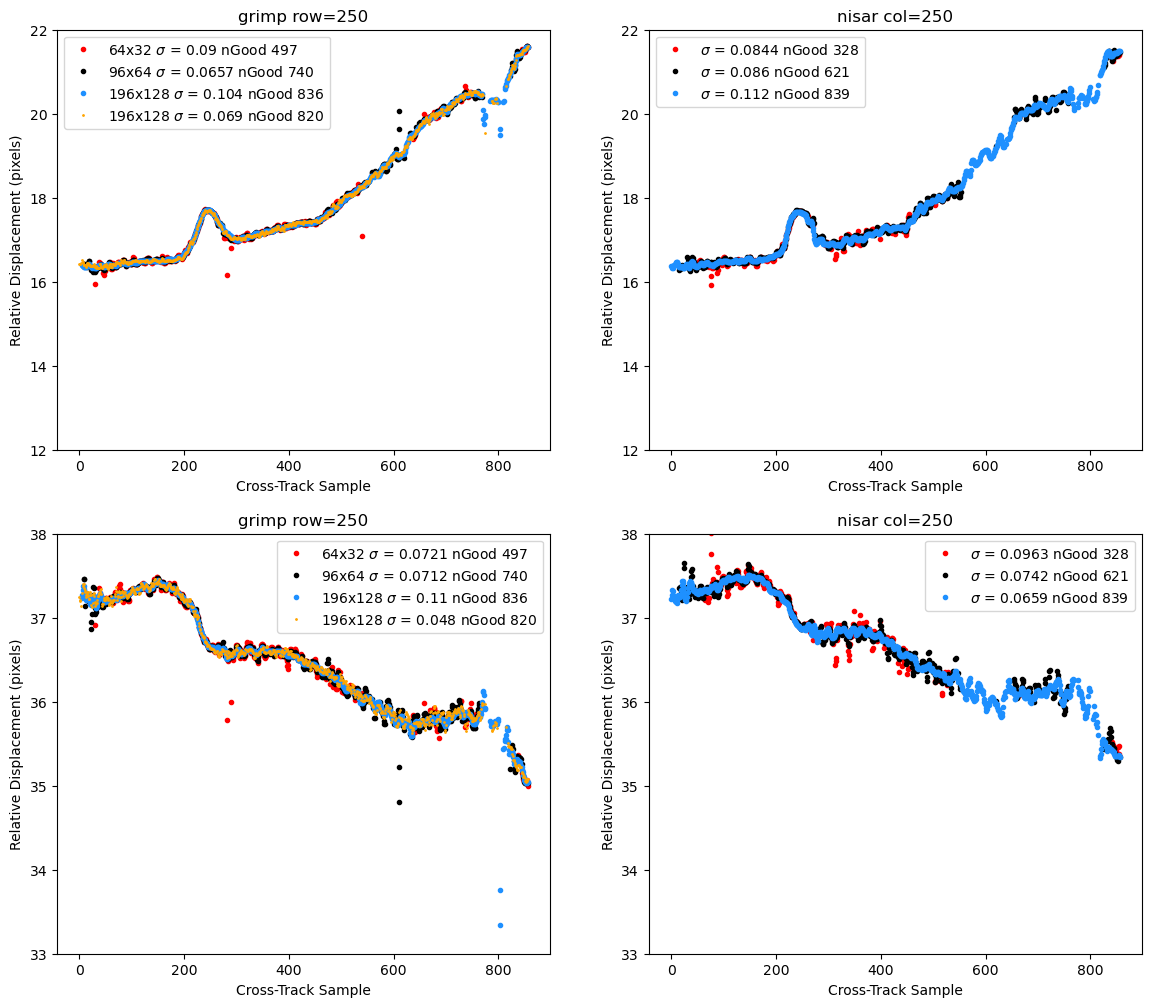

In [12]:
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
row = 250
for band, ax, ylim in zip(bandNames, axes, [[12, 22], [33, 38]] ):
    # Estimate a smoothed version of the smoothest data (196x128)
    dataGrimpSmooth = interpMissing(np.convolve(np.array(getattr(grimpOffsetsCulled['196x128'], band)[row, :]), np.ones(25)/25))
    dataNisarSmooth = interpMissing(np.convolve(np.array(getattr(nisarOffsetsCulled['196x128'], band)[row, :]), np.ones(25)/25))
    for key in keys:
        dataGrimp = np.array(getattr(grimpOffsetsCulled[key], band)[row, :] )
        dataNisar = getattr(nisarOffsetsCulled[key], band)[row, :]   
        # Estimate sigma of high-freq content.
        sigmaG = np.nanstd(dataGrimpSmooth[25:-25] - dataGrimp[13:-13]).item()
        sigmaN = np.nanstd(dataNisarSmooth[25:-25] - dataNisar[13:-13]).item()
        
        labelg = f'{key} $\sigma$ = {sigmaG:.3} nGood {np.sum(np.isfinite(dataGrimp)).item()}'
        ax[0].plot(dataGrimp, '.', color=colors[key], label=labelg)
        labeln = f'$\sigma$ = {sigmaN:.3} nGood {np.sum(np.isfinite(dataNisar)).item()}'
        ax[1].plot(dataNisar, '.', color=colors[key], label=labeln)
    dataCmpx = getattr(complexOffsets, band)[row, :]
    sigmaG = np.nanstd(dataGrimpSmooth[25:-25] - dataCmpx[13:-13]).item()
    labelg = f'{key} $\sigma$ = {sigmaG:.2} nGood {np.sum(np.isfinite(dataCmpx)).item()}'
    ax[0].plot(dataCmpx, '.', color='orange', label=labelg, markersize=2)
    for a, source in zip(ax, [f'grimp row={row}', f'nisar col={row}']):
        a.set_title(source)
        a.legend()
        a.set_ylim(ylim)
        a.set_ylabel('Relative Displacement (pixels)')
        a.set_xlabel('Cross-Track Sample')

### Correlation Comparison

64x32 Correlation
96x64 Correlation
196x128 Correlation


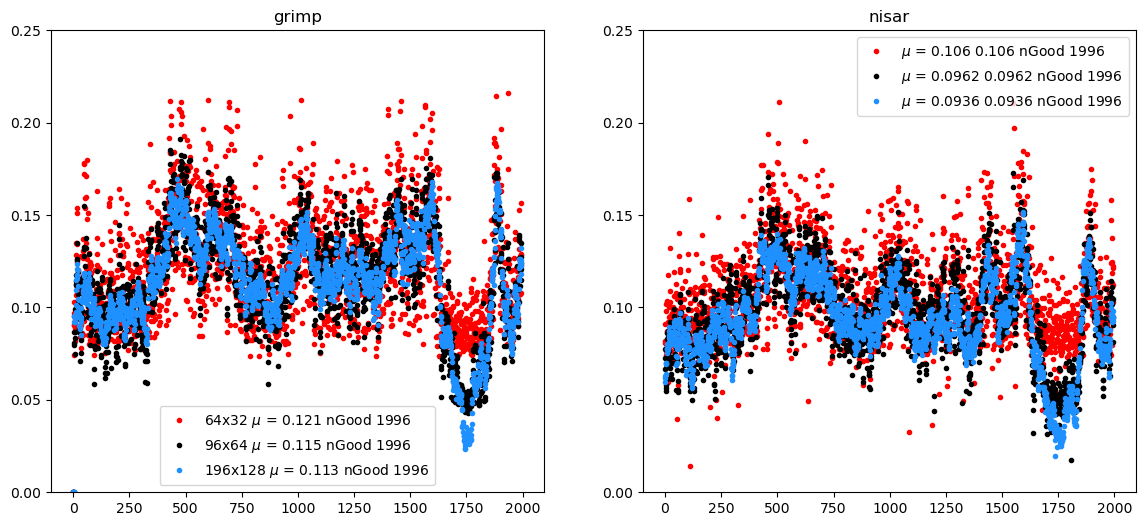

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
col = 500
band = 'Correlation'

for key in keys:
    print(key, band)
    dataGrimp = np.array(getattr(grimpOffsets[key], band)[:, col])
    dataNisar = getattr(nisarOffsets[key], band)[:, col]
    #dataGrimpSmooth = np.convolve(dataGrimp, np.ones(25)/25)
    muGrimp = np.nanmean(dataGrimp).item()
    muNisar = np.nanmean(dataNisar).item()
    labelg = f'{key} $\mu$ = {muGrimp:.3} nGood {np.sum(np.isfinite(dataGrimp)).item()}'
    axes[0].plot(dataGrimp, '.', color=colors[key], label=labelg)
    labeln = f'$\mu$ = {muNisar:.3} {muNisar:.3} nGood {np.sum(np.isfinite(dataNisar)).item()}'
    axes[1].plot(dataNisar, '.', color=colors[key], label=labeln)
for a, source in zip(axes, ['grimp', 'nisar']):
    a.set_title(source)
    a.set_ylim([0,.25])
    a.legend()

### Local Noise from Culler

These plots show the noise levels for the range offsets from the output of the culler using the algorithm described above.

(0.0, 1.0, 0.0, 1.0)

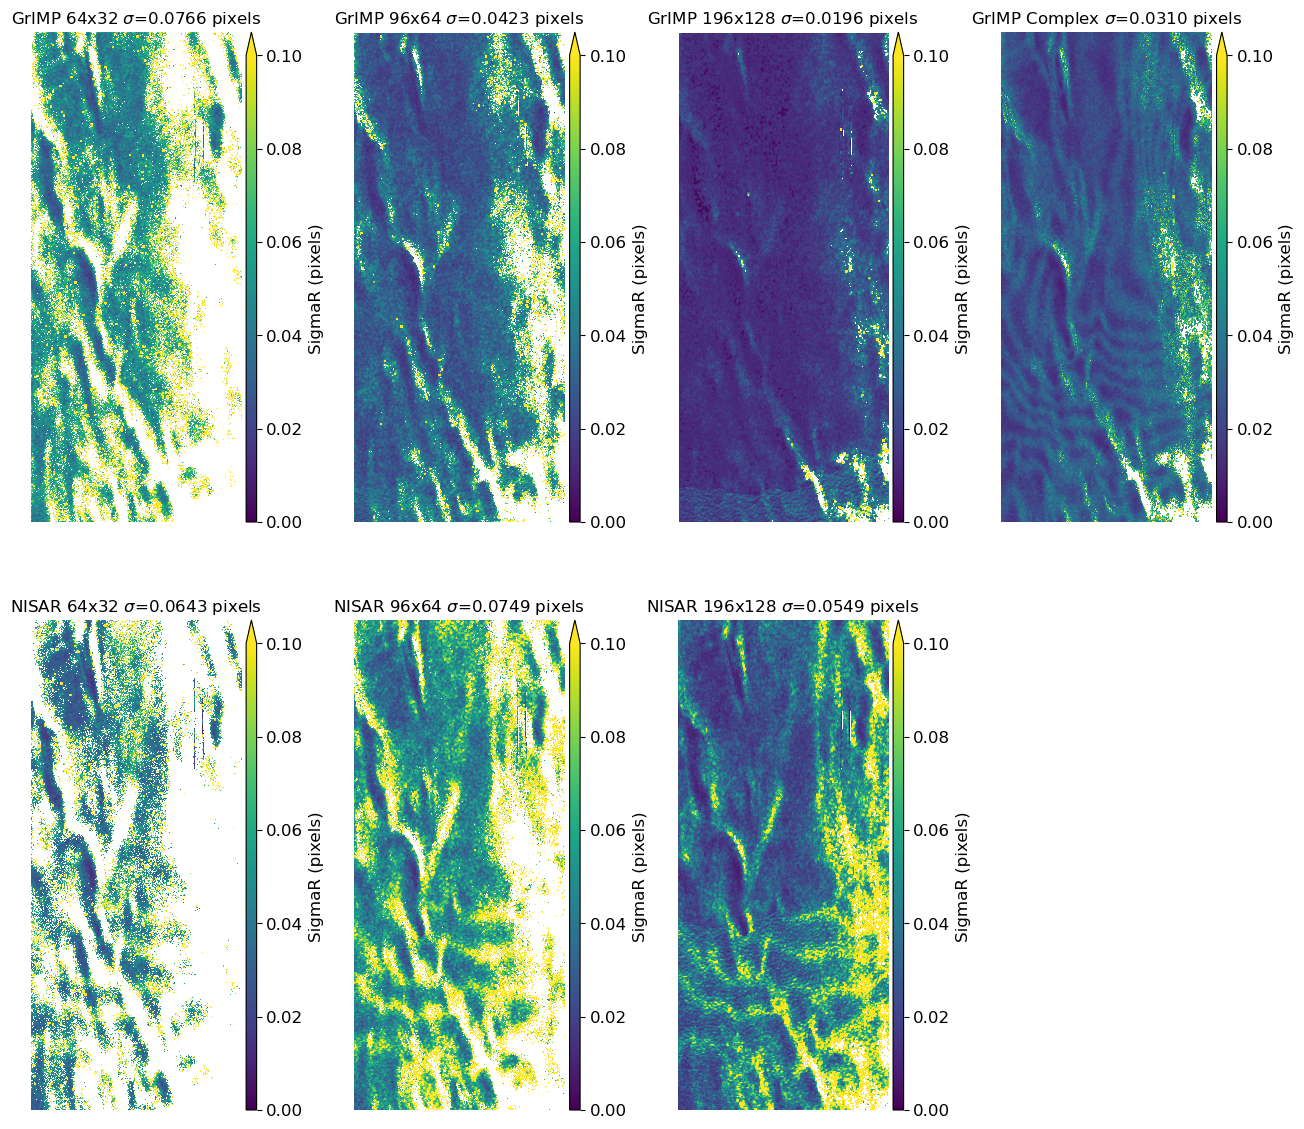

In [14]:
fig, axes = plt.subplots(2, 4, figsize=(16, 14))
band = 'RangeSigma'
for product, axRow, name in zip([grimpOffsetsCulled, nisarOffsetsCulled], axes, ['GrIMP', 'NISAR']):
    for key, ax in zip(keys,  axRow):
        type(product)
        h = ax.imshow(getattr(product[key], band), interpolation='none', vmin=0, vmax=.1)
        sigma = np.nanmean(getattr(product[key], band))
        colorBar(h, ax, 'SigmaR (pixels)', 'right', '5%',.05, 12, 12)
        ax.axis('off')
        ax.set_title(f'{name} {key} $\sigma$={sigma:.4f} pixels')
    sigma = np.nanmean(complexOffsets.RangeSigma)
h = axes[0, 3].imshow(complexOffsets.RangeSigma, interpolation='none', vmin=0, vmax=.1)
colorBar(h, axes[0, 3], 'SigmaR (pixels)', 'right', '5%',.05, 12, 12)
axes[0, 3].axis('off')
axes[0, 3].set_title(f'GrIMP Complex $\sigma$={sigma:.4f} pixels')
axes[1, 3].axis('off')

## Summary 

The results above show that the NISAR correlator is producing noisier offsets (40% or greater) than the GrIMP correlator, but its not clear why since they both ostensibly are doing the same thing. As would be expected, the less noisy GrIMP offsets also provide better coverage after culling.  A mistake in the NISAR code such that the search chip was too small could explain the larger variance. But the correlation is a biased estimator and it tends to decrease with window size (see correlation plot above). In this case, we would expect the NISAR code to be producing larger correlations because the bias would be larger. But instead, its producing lower correlations.

Its not clear whether poor numerical precision in the GPU could be increaing the noise. The next logical step would be to look at a version computed with the CPU version of AMPCORR.